## Looking at first data from DALEC since continuous deployment started

Just going to take a look at the data to see how it looks and test multilog loading

In [1]:
import pandas as pd
import dalecLoad
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [2]:
def load_DALEC_log(filepath, header=216, dropNA=True, longFormat=True, integerIndex=True, removeSaturated=True):
    """
    loads DALEC log file (excluding spectral wavelength mappings)
    optionally returns log file in long format
    option to convert sample no. index to an integer, or to keep as a string (integerIndex)
    """
    # ideally specify dtype of all rows for efficiency and to prevent bad things
    # need to specify str for lots of columns as these have some rows which contain stuff we need to remove
    DALEC_log = pd.read_csv(filepath,
                            header=header,
                            parse_dates=True,
                            dayfirst=True,
                            infer_datetime_format=True,
                            dtype={'Sample #': str,
                                   ' Lat': str, 
                                   ' Lon': str,
                                   ' Solar Azi': str,
                                   ' Solar Elev': str,
                                   ' Relaz': str,
                                   ' Heading': str,
                                   ' Pitch': str,
                                   ' Roll': str,
                                   ' Gearpos': str,
                                   ' Voltage': str,
                                   ' Temp': str,
                                   'Channel': str,
                                   ' Integration Time': str,
                                   ' Saturation Flag': str,
                                   ' Spec[21]': str,
                                   ' Spec[22]': str,
                                  },
                                   
                            )
    
    # any row with invalid UTC date can be removed
    DALEC_log.drop(DALEC_log[DALEC_log[' UTC Date'].isna()].index, inplace = True)
    # this removes the duplicated headings
    DALEC_log.drop(DALEC_log[DALEC_log[' UTC Date'] == 'UTC Date'].index, inplace = True)
    
    if dropNA:
        DALEC_log.dropna(inplace=True, axis=0,)
        
    if longFormat:
        # convert to long format
        # need to test that these variable names always load in this way (leading space on Spec etc.)
        DALEC_log = pd.wide_to_long(DALEC_log, [' Spec['], i=['Sample #', ' Channel'], j='spectral_ind', suffix='\d+]')
        DALEC_log.reset_index(level=2, inplace=True) # remove spectral_ind as an index
        DALEC_log['spectral_ind'] = pd.to_numeric(DALEC_log['spectral_ind'].str[:-1]) # convert spectral_ind to numeric
        DALEC_log.rename(columns={' Spec[': 'Spectral Magnitude'}, inplace=True)
        DALEC_log = DALEC_log.astype({'Spectral Magnitude': 'float64'})
        if integerIndex:
            # change sample no. index to integer
            print('WARNING: some of my old code wont work with integerIndex=True - delete this line once this is sorted')
            idx = DALEC_log.index
            DALEC_log.index = DALEC_log.index.set_levels([idx.levels[0].astype(int), idx.levels[1]])
        # sort index
        DALEC_log.sort_index(inplace=True)
        # change saturation flag to int.
        DALEC_log[' Saturation Flag'] = DALEC_log[' Saturation Flag'].astype(int)
        # format column as datetimes
        DALEC_log[' UTC Date'] = pd.to_datetime(DALEC_log[' UTC Date'], dayfirst=True, infer_datetime_format=True)
        # remove saturated readings - this hasn't been tested on a df which isn't in long format!
        if removeSaturated:
            indSat = DALEC_log[DALEC_log[' Saturation Flag'] == 1].index.get_level_values(0)
            if list(indSat): # checks if the list is empty
                DALEC_log.drop(indSat, level=0, axis=0, inplace=True)

    return DALEC_log


In [4]:
log71 = dalecLoad.load_DALEC_log('data/Jul-Aug/DALEC_71.dtf', integerIndex=True)

In [5]:
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths('data/Jul-Aug/DALEC_71.dtf')

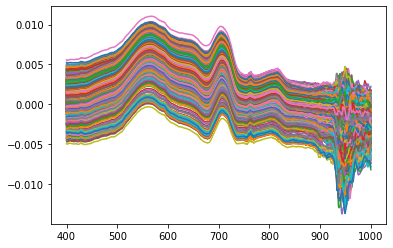

In [6]:
fig, ax = plt.subplots()
for sample in log71.index.get_level_values('Sample #').unique():
        spectra = dalecLoad.uniform_grid_spectra_Rrs(log71.loc[sample],
                                       spect_wavelengths)
        ax.plot(spectra['Wavelength'], (spectra['Rrs']))

In [8]:
# think this is fine - looks like it works 

def multiLogLoad(filepath, 
                 sep=['DALEC (SN:0005)'],
                 header=216, 
                 dropNA=True,longFormat=True, 
                 integerIndex=True,
                 removeSaturated=True):
    """
    - loads multiple logs which are all contained in a single logfile (eg. that was generated using serial logging of DALEC
    - depending on how the logfile was generated, adjusting 'sep' might allow for different situations...
    - should probably think a bit more about this for a continuous logging application
    """
    # ideally specify dtype of all rows for efficiency and to prevent bad things - TODO!
    # need to specify str for lots of columns as these have some rows which contain stuff we need to remove
    col_names = pd.read_csv(filepath, nrows=0, header=header,).columns
    types_dict = {} # if I want to be more specific then I can specify any cols which I don't want to be str
    types_dict.update({col: str for col in col_names if col not in types_dict})
    types_dict.pop(' UTC Date', ' UTC Time') # want these to be formatted as datetime by pd.read_csv
    
    df = pd.read_csv(filepath,
                     header=header,
                     parse_dates=True,
                     dayfirst=True,
                     infer_datetime_format=True,
                     dtype=types_dict,
                     )
    
    groups = df['Sample #'].isin(sep).cumsum()
    names = ['Log ' + str(i) for i in range(len(set(groups)))] 
    tables = {name: g[1].iloc[1:] for g,name in zip(df.groupby(groups), names)} 
    # because we've used 'DALEC (SN:0005)' as the way to seperate logfiles, we need to remove the first lines before this
    # if a different sep is used, then this line may no longer work... so perhaps need to make this more robust!
    tables.pop('Log 0')
    print(len(tables))
    for name, table in tables.items():
        # any row with invalid UTC date can be removed
        table.drop(table[table[' UTC Date'].isna()].index, inplace = True)
        # this removes the duplicated headings
        table.drop(table[table[' UTC Date'] == 'UTC Date'].index, inplace = True)
        if dropNA:
            table.dropna(inplace=True, axis=0,)
        if longFormat:
            # convert to long format
            # need to test that these variable names always load in this way (leading space on Spec etc.)
            table = pd.wide_to_long(table, [' Spec['], i=['Sample #', ' Channel'], j='spectral_ind', suffix='\d+]')
            table.reset_index(level=2, inplace=True) # remove spectral_ind as an index
            table['spectral_ind'] = pd.to_numeric(table['spectral_ind'].str[:-1]) # convert spectral_ind to numeric
            table.rename(columns={' Spec[': 'Spectral Magnitude'}, inplace=True)
            table = table.astype({'Spectral Magnitude': 'float64'})
        if integerIndex:
            # change sample no. index to integer
            print('WARNING: some of my old code wont work with integerIndex=True - delete this line once this is sorted')
            idx = table.index
            table.index = table.index.set_levels([idx.levels[0].astype(int), idx.levels[1]])
        # sort index
        table.sort_index(inplace=True)
        # change saturation flag to int.
        table[' Saturation Flag'] = table[' Saturation Flag'].astype(int)
        # format column as datetimes
        table[' UTC Date'] = pd.to_datetime(table[' UTC Date'], dayfirst=True, infer_datetime_format=True)
        # remove saturated readings - this hasn't been tested on a df which isn't in long format!
        if removeSaturated:
            indSat = table[table[' Saturation Flag'] == 1].index.get_level_values(0)
            if list(indSat): # checks if the list is empty
                table.drop(indSat, level=0, axis=0, inplace=True)
        
        tables[name] = table
    return tables

In [69]:
# my current understanding is that multiLogLoad works if we use 'Sample #' as the sep AND we accept that data which came in
# from the serial port might be missing lines. So far this has resulted in a TypeError, but could give other errors I think...
# good to keep an eye on this to find out if other types of errors occur

tables = dalecLoad.multiLogLoad('data/Jul-Aug/DALEC_72_73.dtf', sep=['Sample #'])

In [70]:
tables['Log 2']

spectral_ind  GPS_Fix  Integration Time  Pitch    Temp  \
Sample #  Channel                                                           
7248     Ed                  21        F                57    0.0    37.5   
         Ed                  22        F                57    0.0    37.5   
         Ed                  23        F                57    0.0    37.5   
         Ed                  24        F                57    0.0    37.5   
         Ed                  25        F                57    0.0    37.5   
...                         ...      ...               ...    ...     ...   
10939    Lu                 216        F                96    0.0  29.375   
         Lu                 217        F                96    0.0  29.375   
         Lu                 218        F                96    0.0  29.375   
         Lu                 219        F                96    0.0  29.375   
         Lu                 220        F                96    0.0  29.375   

                    UTC Date      UTC Time  Solar Azi  Voltage         Lat  \
Sample #  Channel                                                            
7248     Ed       2022-07-30  10:00:04.150      130.1     11.6  56.1468505   
         Ed       2022-07-30  10:00:04.150      130.1     11.6  56.1468505   
         Ed       2022-07-30  10:00:04.150      130.1     11.6  56.1468505   
         Ed       2022-07-30  10:00:04.150      130.1     11.6  56.1468505   
         Ed       2022-07-30  10:00:04.150      130.1     11.6  56.1468505   
...                      ...           ...        ...      ...         ...   
10939    Lu       2022-07-30  11:59:58.886      171.4     11.6  56.1468505   
         Lu       2022-07-30  11:59:58.886      171.4     11.6  56.1468505   
         Lu       2022-07-30  11:59:58.886      171.4     11.6  56.1468505   
         Lu       2022-07-30  11:59:58.886      171.4     11.6  56.1468505   
         Lu       2022-07-30  11:59:58.886      171.4     11.6  56.1468505   

                    Relaz  Solar Elev          Lon   Saturation Flag  Heading  \
Sample #  Channel                                                               
7248     Ed        -138.2        43.9  -3.92305679                 0     33.2   
         Ed        -138.2        43.9  -3.92305679                 0     33.2   
         Ed        -138.2        43.9  -3.92305679                 0     33.2   
         Ed        -138.2        43.9  -3.92305679                 0     33.2   
         Ed        -138.2        43.9  -3.92305679                 0     33.2   
...                   ...         ...          ...               ...      ...   
10939    Lu        -135.9        52.1  -3.92305679                 0     35.5   
         Lu        -135.9        52.1  -3.92305679                 0     35.5   
         Lu        -135.9        52.1  -3.92305679                 0     35.5   
         Lu        -135.9        52.1  -3.92305679                 0     35.5   
         Lu        -135.9        52.1  -3.92305679                 0     35.5   

                   Roll  Gearpos  Spectral Magnitude  
Sample #  Channel                                     
7248     Ed        -1.0    -62.2            0.107953  
         Ed        -1.0    -62.2            0.108974  
         Ed        -1.0    -62.2            0.106759  
         Ed        -1.0    -62.2            0.101189  
         Ed        -1.0    -62.2            0.100306  
...                 ...      ...                 ...  
10939    Lu        -2.0    -57.3            0.001343  
         Lu        -2.0    -57.3            0.000877  
         Lu        -2.0    -57.3            0.000989  
         Lu        -2.0    -57.3            0.000968  
         Lu        -2.0    -57.3            0.000838  

[2212800 rows x 18 columns]

KeyError


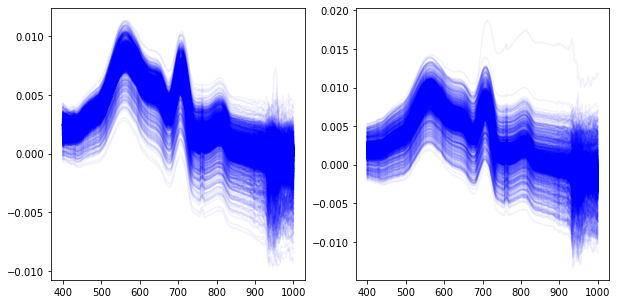

In [72]:
# the TRY PASS thing works nicely for plotting! 

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for i in range(len(tables)):
    ind = list(tables.keys())[i]
    for sample in tables[ind].index.get_level_values('Sample #').unique():
        try:
            spectra = dalecLoad.uniform_grid_spectra_Rrs(tables[ind].loc[sample],
                                               spect_wavelengths)
            ax[i].plot(spectra['Wavelength'], (spectra['Rrs']), color='b', alpha=0.05)
        except KeyError:
            # worth investigating more if there ever seems to be a very large number of KeyErrors
            print('KeyError')
            pass

In [62]:
np.array(tables['Log 1'].index.values)

for i in range(3613, 7247):
    print(i)
    tables['Log 1'].loc[i, 'Lsky']
    # so this breaks at sample number = 6224

3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812


5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451


KeyError: 'Lsky'

In [63]:
tables['Log 1'].loc[6224, :].shape
# okay so this only has 400 rows, and each channel should have 200 wavelengths on it, so we expect 600!

# when inspecting the log file, I find that there is a line missing at 6224!
# this means my code is fine, but the serial data failed to read this line for some reason.
# so, probably just skip this sample? - can use try except

6224


(400, 18)

In [66]:
for i in range(6225, 7248):
    print(i)
    tables['Log 1'].loc[i, 'Lsky']
    # this doesn't break! 

6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347
6348
6349
6350
6351
6352
6353
6354
6355
6356
6357
6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
